In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
PIXELS_PER_METER = 420 / 3.7 # approximately

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

In [11]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
#nxpd.draw(runner.token_manager.to_networkx())

In [12]:
def curvature_poly2(params, at_point):
    
    a, b, _ = params
    return ((1 + (2 * a * at_point + b) ** 2) ** 1.5) / np.abs(2 * a)


def lane_center(poly_x_left, poly_x_right, last_n=15):
    return poly_x_left[-last_n:] + (poly_x_right[-last_n:] - poly_x_left[-last_n:])

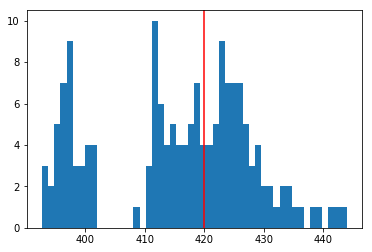

In [13]:
diffs_list = []

for im in test_images_undist:
    
    runner.run(image=im, M=M, Minv=Minv)
    diffs = lane_center(runner['poly_x_left'], runner['poly_x_right'], last_n=20)
    diffs_list.append(diffs)
    
all_diffs = np.concatenate(diffs_list)

_ = plt.hist(all_diffs, bins=50)
plt.axvline(420, color='r')

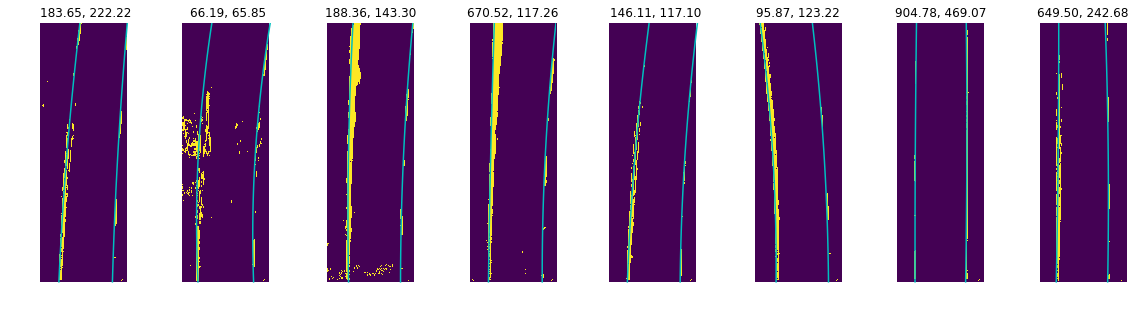

In [14]:
last_y = CANVAS_SZ[1]

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    plt.plot(runner['poly_x_left'], runner['poly_y'], color='c')
    plt.plot(runner['poly_x_right'], runner['poly_y'], color='c')
    
    curv_left = curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left / PIXELS_PER_METER, curv_right / PIXELS_PER_METER))